In [36]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2
from joblib import Parallel, delayed
import math
import os
import ast
import gc
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from pathlib import Path
from sklearn.preprocessing import RobustScaler
from typing import Tuple, List
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#loading ground truth - concat all the ground truth anomalous agents to gt

# sim 1 anomalies
gt1 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_agent (1).csv')
gt2 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_agent (2).csv')
gt3 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_agent (3).csv')
gt4 = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/gt/anomalous_agent (4).csv')

gt = pd.concat([gt1, gt2, gt3, gt4]).drop_duplicates().reset_index(drop=True)

#sim2

# gt = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim2/ta5_vae_sim2_KSP_NT.csv')
# gt = gt[gt['label_x'] == 1]
# gt.rename(columns={'user_id': 'agent'}, inplace=True)

# loading residents (something we internally processed to find agents who show consistant resident behaviour in past and future)

res = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/Sim1_Trial5_Agent_Classification.csv', low_memory=False)
res = res[(res['past_classification'] == 'residents') & (res['future_classification'] == 'residents')]

# here we calculated the amount of hours of difference presence in the simulation past vs present (you can find the function hidden above that used to create this)
time_diff = pd.read_parquet('/Users/chanuka/Desktop/codespaces/liad/framework/tsm/t5_sim1_agent_durations.parquet')
time_diff['difference'] = abs(time_diff['train_duration'] - time_diff['test_duration'])

### Results

In [58]:
# the created anomaly score dataset from tsm_weekly
tsm = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/2m/weekly_max.csv')
ore = pd.read_csv('/Users/chanuka/Desktop/codespaces/liad/processed/trial5/sim1/2m/ore.csv')
anomaly_df = tsm.merge(ore, on='agent', how='inner')


# # # Method 01: Convert scores to percentiles (0 to 1 scale)
# anomaly_df['rank_1'] = anomaly_df['anomaly_score'].rank(pct=True)
# anomaly_df['rank_2'] = anomaly_df['agent_anomaly_score'].rank(pct=True)
# # Combine (Mean or Max)
# anomaly_df['anomaly_score'] = anomaly_df[['rank_1', 'rank_2']].max(axis=1)

# Method 02: standard scaling
# scaler = StandardScaler()
# anomaly_df[['s1_scaled', 's2_scaled']] = scaler.fit_transform(anomaly_df[['anomaly_score', 'agent_anomaly_score']])
# # # Combine with optional weights
# anomaly_df['anomaly_score'] = (anomaly_df['s1_scaled'] * 0.5) + (anomaly_df['s2_scaled'] * 0.5)


# # # Method 03: Max to find if either method flagged the agent
scaler = MinMaxScaler()
anomaly_df[['s1_minmax', 's2_minmax']] = scaler.fit_transform(anomaly_df[['anomaly_score', 'agent_anomaly_score']])
anomaly_df['anomaly_score'] = anomaly_df[['s1_minmax', 's2_minmax']].max(axis=1)


anomaly_df = anomaly_df[anomaly_df['agent'].isin(res['agent'].values)]
gt_anomaly_agents = set(gt['agent'].values)
anomaly_df['is_anomaly'] = 0
anomaly_df['is_anomaly'] = anomaly_df['agent'].isin(gt_anomaly_agents).astype(int)

anomaly_df = anomaly_df.merge(time_diff[['agent', 'difference']], on='agent', how='left')
anomaly_df = anomaly_df.fillna(0)

# Attention: this step can be commented out -its just setting the time difference of past vs present less than 3000
anomaly_df = anomaly_df[anomaly_df['difference'] < 2900]

In [59]:
anomaly_df.sort_values(by = 'anomaly_score', ascending=False).head(60)

,agent,anomaly_score,agent_anomaly_score,s1_minmax,s2_minmax,is_anomaly,difference
1187711,1505192,1.0,1.0,1.000000,1.0,1,2617.833333
449127,569028,1.0,1.0,0.315734,1.0,0,2784.833333
829912,1052909,1.0,1.0,0.303106,1.0,0,2467.666667
1067428,1353844,1.0,1.0,0.225856,1.0,0,2570.166667
949399,1203969,1.0,1.0,0.240635,1.0,0,2747.666667
485638,615356,1.0,1.0,0.091789,1.0,0,2888.166667
377621,478565,1.0,1.0,0.292706,1.0,0,0.000000
1101254,1396730,1.0,1.0,0.131755,1.0,0,2781.333333
1406587,1783339,1.0,1.0,0.240095,1.0,0,2799.833333
395833,501174,1.0,1.0,0.282063,1.0,0,2769.833333


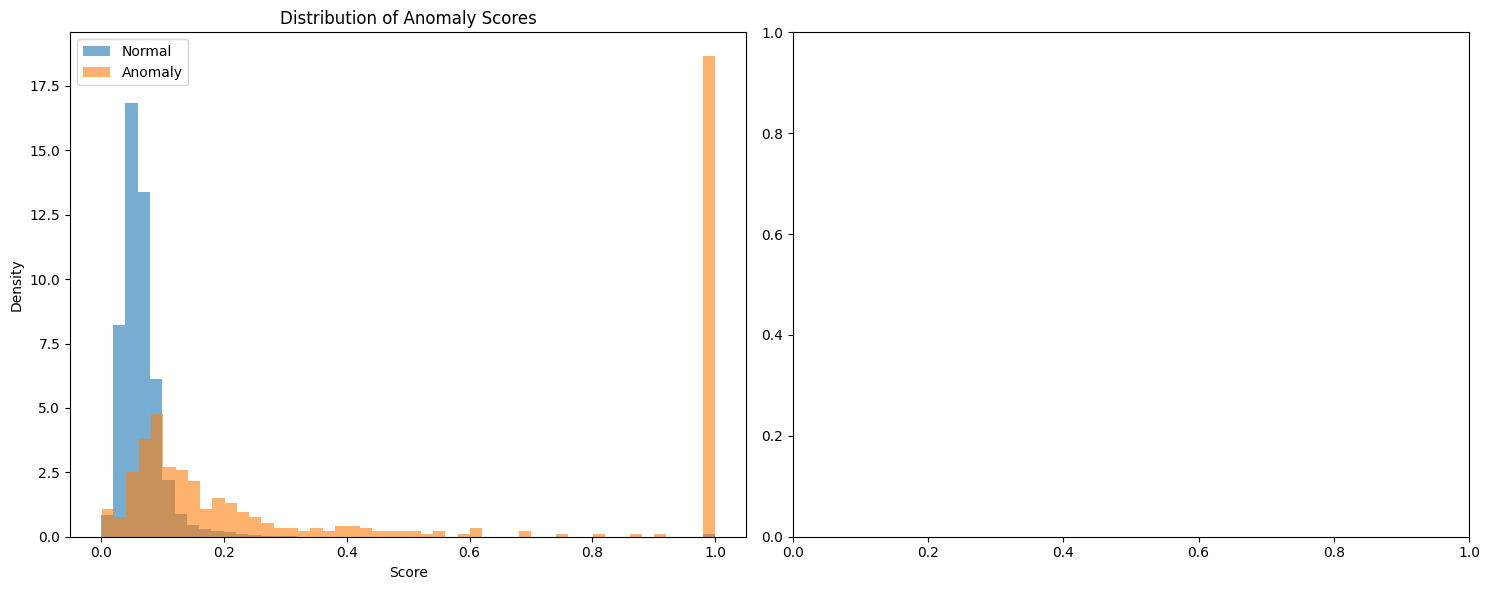

In [60]:
import matplotlib.pyplot as plt

# Data Prep
normal_scores  = anomaly_df[anomaly_df["is_anomaly"] == 0]["anomaly_score"]
anomaly_scores = anomaly_df[anomaly_df["is_anomaly"] == 1]["anomaly_score"]
# diff_normal    = anomaly_df[anomaly_df["is_anomaly"] == 0]["difference"]
# diff_anomaly   = anomaly_df[anomaly_df["is_anomaly"] == 1]["difference"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Left Plot: Anomaly Scores
ax1.hist(normal_scores, bins=50, alpha=0.6, label="Normal", density=True)
ax1.hist(anomaly_scores, bins=50, alpha=0.6, label="Anomaly", density=True)
ax1.set_title("Distribution of Anomaly Scores")
ax1.set_xlabel("Score")
ax1.set_ylabel("Density")
ax1.legend()

# # # Right Plot: Duration Diff (Split by Label)
# ax2.hist(diff_normal, bins=50, alpha=0.6, label="Normal", density=True)
# ax2.hist(diff_anomaly, bins=50, alpha=0.6, label="Anomaly", density=True)
# ax2.set_title("Distribution of Duration Shift")
# ax2.set_xlabel("abs_duration_diff (minutes)")
# ax2.legend()

plt.tight_layout()
plt.show()

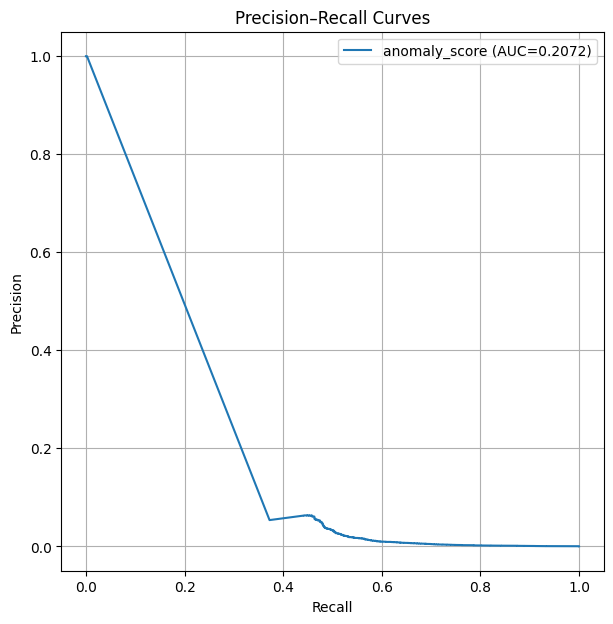

In [61]:
score_cols = [
    "anomaly_score"
]

y_true = anomaly_df["is_anomaly"].astype(int).values

plt.figure(figsize=(7, 7))

for col in score_cols:
    if col not in anomaly_df.columns:
        print(f"Skipping {col} (not found)")
        continue

    # drop rows where this score is NaN
    mask = ~anomaly_df[col].isna()
    if mask.sum() == 0:
        print(f"Skipping {col} (all NaN)")
        continue

    precision, recall, thresholds = precision_recall_curve(
        y_true[mask.values],
        anomaly_df.loc[mask, col].values
    )

    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{col} (AUC={pr_auc:.4f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()